## Table of Contents
* [Loading the Data](#Introduction)
* [Missing Values](#Data_Preparation)
    * [Checking Missing Values]()
    * [Embarked Missing Values]()
    * [Age Missing Values Manually]()
    * [Fare Missing Values]()
    * [Age Missing Values with Linear Regression]()
* [Categorical Features Analysis](#Building_the_Models)
    * [Analysis]()
    * [Parity of Cabin Number Feature]()
    * [Cabin Letter Feature]()
* [One Hot Encoding Categorical Data](#Training_)
* [Numeric Data](#Evaluation_of_Models)
    * [Family Size Feature]()
    * [Analysis]()
    * [Normalization]()
    * [Age Featuring](#Variance)
* [Preparing Training & Test Data](#Submissions)
* [Model Building](#Submissions)
* [Hyper Parameter Tuning](#Submissions)
    * [Randomized Search Tuning]()
    * [Grid Search Tuning]()
    * [Bayes Search Tuning]()
* [Esembles using a Voting Classifier](#Submissions)
* [Evaluation Metrics](#Submissions)
    * [Classification Reports]()
    * [ROC curves]()

# 1. Loading the Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math #Lot's of things but here i use the math.isnan() function to check for nan values

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt #Plotting diagrams
import seaborn as sns #Plotting diagrams
%matplotlib inline 
#Te quitas errores al usar plt o sns

In [3]:
dtrain = pd.read_csv("/kaggle/input/titanic/train.csv") #This is the training set
dtest = pd.read_csv("/kaggle/input/titanic/test.csv") #This is the test set
dgender = pd.read_csv("/kaggle/input/titanic/gender_submission.csv") #THIS IS THE OUTPUTS OF THE TEST SET


Let's take a look at the data that we are given.

In [4]:
dtrain['train_test'] = 1 #ADDS column 'train_test' with 1's.
dtest['train_test'] = 0 #ADDS column 'train_test' with 0's.
dtest['Survived'] = np.NaN #ADDS column 'Survived' with NaN object.
all_data = pd.concat([dtrain,dtest]) #Joins both dataframes 
print(all_data)

     PassengerId  Survived  Pclass  \
0              1       0.0       3   
1              2       1.0       1   
2              3       1.0       3   
3              4       1.0       1   
4              5       0.0       3   
..           ...       ...     ...   
413         1305       NaN       3   
414         1306       NaN       1   
415         1307       NaN       3   
416         1308       NaN       3   
417         1309       NaN       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

 **Let's first analyse the data**

In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  train_test   1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.2+ KB


In [6]:
all_data.describe()
# to better understand the numeric data, 
# we want to use the .describe() method. This gives us 
# an understanding of the central tendencies of the data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


In [7]:
# look at numeric and categorical values separately 
df_cat = all_data[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

# 2. Missing values

There is many ways of replacing missing values in a feature. Some of the most popular methods are replacing missing values by the mean or median, depending on the distribution of the feature. If data is skewed or has outliers, median is better. If data follows a normal distribution, mean is better. 

However sometimes there are $smarter$ ways to handle these missing values. For example we can use other features for which we know the values and use the data to predict from these other features what the unknown feature value is. In this section I do this in a manual way on the Age feature. One can also use ML algorithms to fill in the missing values, I also use this method at the end of this section. We will see which one is better, but because of the simplicity of the data, they should be similar. 

## 2.1. Checking Missing Values

In [8]:
all_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
train_test        0
dtype: int64

There is 263 missing values of age which should be an important feature. There's als a lot of missing values for Cabin which is going to make it impossible to fill the values in a sensible way. I first fix the Embarked values, which can be found by searching on Google.

## 2.2. Embarked Missing Values

In [9]:
all_data[all_data['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1


Googling both these persons I found that Miss. Amelie was Martha Evelyn's maid and they boarded the Titanic from Charlestown. Let's fill their embarkment as C.

In [10]:
all_data['Embarked'].fillna('C',inplace=True)

## 2.3. Age Missing Values Manually

Now we start filling the missing values of Age. Let's see on the ones we know if there's correlation between age and other categories. The first thing that comes to mind is the name. Clearly a Mr is not going to be a kid. Let's do some feature engineering on age.

In [11]:
#Selecting the title a person had 
all_data.Name.head(50)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
print(all_data['name_title'].value_counts())
#mr., ms., master. etc

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: name_title, dtype: int64


Looks like Mr, Miss, Mrs and Master are the most popular. 

Although Mlle is French for Miss (unmarried) and Mme is French for Mrs. Hence we are going to group these. Ms is also another way of saying Miss.

In order to reduce time computation due to too many features we are also going to group the least common features into an LeastCommontitles group.

In [12]:
# Recategorize uncommon titles that fit into "Miss." and "Mrs."
all_data.loc[all_data['name_title'].isin(['Ms', 'Mlle']), 'name_title'] = 'Miss'
all_data.loc[all_data['name_title'].isin(['Mme']), 'name_title'] = 'Mrs'

# Create new title 'Uncommon'
LeastCommontitles = ['Major', 'Lady', 'Sir', 'Don', 'Capt', 'Countess', 'Jonkheer', 'Dona', 'Dr', 'Rev', 'Col', 'the Countess']
all_data.loc[all_data['name_title'].isin(LeastCommontitles), 'name_title'] = 'Uncommon'

# Display count of each title 
display(all_data['name_title'].value_counts())

Mr          757
Miss        264
Mrs         198
Master       61
Uncommon     29
Name: name_title, dtype: int64

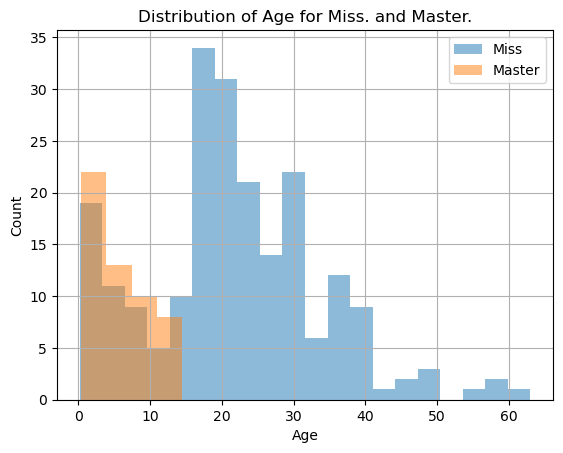

In [13]:
all_data[all_data['name_title']=='Miss']['Age'].dropna().hist(alpha=0.5, bins=20, label='Miss')
all_data[all_data['name_title']=='Master']['Age'].dropna().hist(alpha=0.5, bins=4, label='Master')

plt.title('Distribution of Age for Miss. and Master.')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

As we can see from the plot above, Master is used for men under the age of 18.


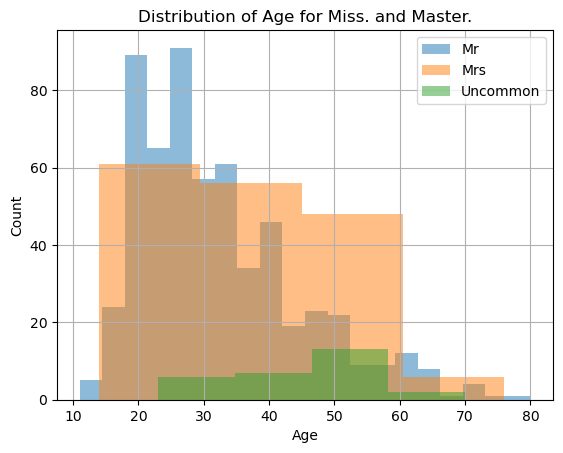

In [14]:
all_data[all_data['name_title']=='Mr']['Age'].dropna().hist(alpha=0.5, bins=20, label='Mr')
all_data[all_data['name_title']=='Mrs']['Age'].dropna().hist(alpha=0.5, bins=4, label='Mrs')
all_data[all_data['name_title']=='Uncommon']['Age'].dropna().hist(alpha=0.5, bins=4, label='Uncommon')

plt.title('Distribution of Age for Miss. and Master.')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Now I am going to fill in the missing values of age with the mean of the title the person corresponds to.

In [15]:
all_data.groupby('name_title').Age.mean()

name_title
Master       5.482642
Miss        21.824366
Mr          32.252151
Mrs         36.918129
Uncommon    45.178571
Name: Age, dtype: float64

In [16]:
def agefiller(x):
    if x.name_title=='Master':
        return 5
    elif x.name_title=='Miss':
        return 22
    elif x.name_title=='Mr':
        return 32
    elif x.name_title=='Mrs':
        return 37
    elif x.name_title=='Uncommon':
        return 45
all_data['Age']=all_data.apply(lambda x: agefiller(x) if math.isnan(x.Age)==True else x.Age, axis =1)
print(all_data.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          0
train_test        0
name_title        0
dtype: int64


## 2.4. Fare Missing Values 

For Fair there's only one missing value so it is reasonable to fill it with mean or median. Let's first see how it is distributed.

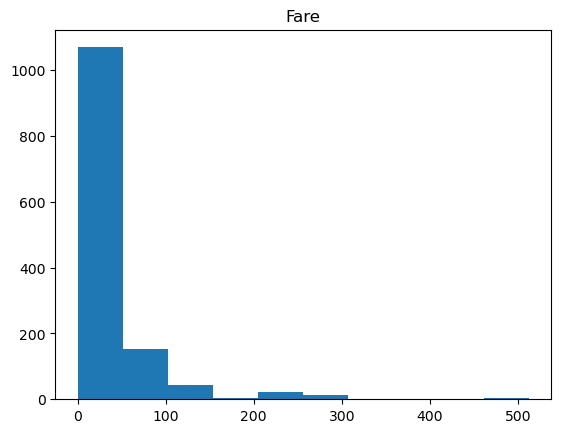

In [17]:
plt.hist(all_data['Fare'])
plt.title('Fare')
plt.show()

We can see there are some outliers, however checking the tickets there are some tickets repeating. This means that some tickets could have been sold in groups affecting the Fare. To solve this problem let's create a Ticket_group_size feature and a Fare_per_passenger feature.

There's more tickets than ticket numbers so maybe tickets booked together have the same number. Meaning we can tell if individuals were travelling acompanied or not (we can also tell this from Parch and SibSp, but this also includes non-family members). 

In [18]:
all_data['Ticket_group_size'] = all_data.groupby('Ticket')['Ticket'].transform('count')
print(all_data['Ticket_group_size'])

0      1
1      2
2      1
3      2
4      1
      ..
413    1
414    3
415    1
416    1
417    3
Name: Ticket_group_size, Length: 1309, dtype: int64


In [19]:
all_data['Fare_per_passenger'] = all_data['Fare'] / all_data['Ticket_group_size']

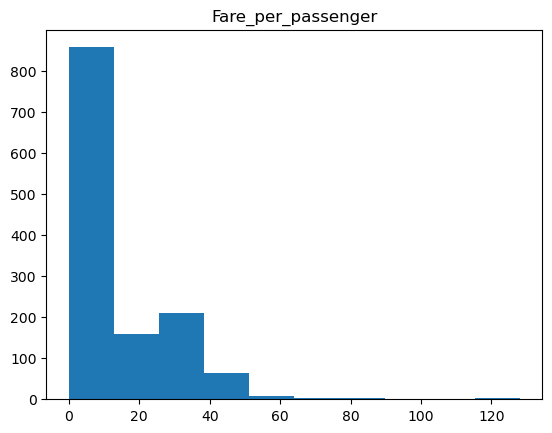

In [20]:
plt.hist(all_data['Fare_per_passenger'])
plt.title('Fare_per_passenger')
plt.show()

We have clearly gotten rid of outliers. However it seems that the Fare_per_passenger is still skewed so it is reasonable to fill the missing values with median.

In [21]:
all_data.Fare_per_passenger = all_data.Fare_per_passenger.fillna(all_data.Fare_per_passenger.median())

## 2.5. Age Missing Values with Linear Regression

In this subsection instead of filling the missing values for age manually as we did above, we will use an ML algorithm that predicts the age features based on the rest of the features. This is done by training it, but now the output is the age feature instead of survived/not survived. Since the age feature is numeric we are dealing with a regression problem. I will use linear regression. I will have to perform one hot encoding since some of the features are categorical. 


In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
all_data_forage = all_data
all_data_forage.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test',
       'name_title', 'Ticket_group_size', 'Fare_per_passenger'],
      dtype='object')

In [24]:
all_data_forage.Age.dropna()
all_data_forage.Age.value_counts()

32.0    200
22.0     94
24.0     47
21.0     41
30.0     40
       ... 
23.5      1
70.5      1
55.5      1
20.5      1
38.5      1
Name: Age, Length: 98, dtype: int64

In [25]:
X_trainforage = all_data_forage.drop(['Age', 'Name', 'Fare', 'Ticket', 'train_test', 'PassengerId', 'Cabin'], axis =1)
Y_age = all_data_forage['Age']
X_trainforage.columns

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'name_title',
       'Ticket_group_size', 'Fare_per_passenger'],
      dtype='object')

In [26]:
ohe = OneHotEncoder()
onehottrainage = ohe.fit_transform(all_data_forage[['Pclass', 'Sex', 'name_title', 'Embarked']]).toarray()
#fit_transform first encodes(fits) data and then transforms it from OneHotEncoder type to list
features_labelsage = ohe.categories_ #This is an array of arrays
print(features_labelsage)
features_labelsage1 = np.hstack(features_labelsage)#This is an array of objects

[array([1, 2, 3]), array(['female', 'male'], dtype=object), array(['Master', 'Miss', 'Mr', 'Mrs', 'Uncommon'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]


In [27]:
onehotfeaturesage = pd.DataFrame(np.array(onehottrainage), columns= features_labelsage1)
print(onehotfeaturesage)

        1    2    3  female  male  Master  Miss   Mr  Mrs  Uncommon    C    Q  \
0     0.0  0.0  1.0     0.0   1.0     0.0   0.0  1.0  0.0       0.0  0.0  0.0   
1     1.0  0.0  0.0     1.0   0.0     0.0   0.0  0.0  1.0       0.0  1.0  0.0   
2     0.0  0.0  1.0     1.0   0.0     0.0   1.0  0.0  0.0       0.0  0.0  0.0   
3     1.0  0.0  0.0     1.0   0.0     0.0   0.0  0.0  1.0       0.0  0.0  0.0   
4     0.0  0.0  1.0     0.0   1.0     0.0   0.0  1.0  0.0       0.0  0.0  0.0   
...   ...  ...  ...     ...   ...     ...   ...  ...  ...       ...  ...  ...   
1304  0.0  0.0  1.0     0.0   1.0     0.0   0.0  1.0  0.0       0.0  0.0  0.0   
1305  1.0  0.0  0.0     1.0   0.0     0.0   0.0  0.0  0.0       1.0  1.0  0.0   
1306  0.0  0.0  1.0     0.0   1.0     0.0   0.0  1.0  0.0       0.0  0.0  0.0   
1307  0.0  0.0  1.0     0.0   1.0     0.0   0.0  1.0  0.0       0.0  0.0  0.0   
1308  0.0  0.0  1.0     0.0   1.0     1.0   0.0  0.0  0.0       0.0  1.0  0.0   

        S  
0     1.0  
1  

In [28]:
reg = LinearRegression().fit(onehotfeaturesage, Y_age)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [29]:
all_data_forage['Age']=all_data.apply(lambda x: reg.predict(x) if math.isnan(x.Age)==True else x.Age, axis =1)

# 3. Categorical Features

## 3.1. Analysis

In [30]:
print("Lets see the number of passengers in each class")
print(df_cat['Pclass'].value_counts()) #Esto es un Series object

#This is just to show what 
# the code bellow is doing

print(df_cat['Pclass'].value_counts().index) #Esto es casi como un array

Lets see the number of passengers in each class
3    709
1    323
2    277
Name: Pclass, dtype: int64
Int64Index([3, 1, 2], dtype='int64')


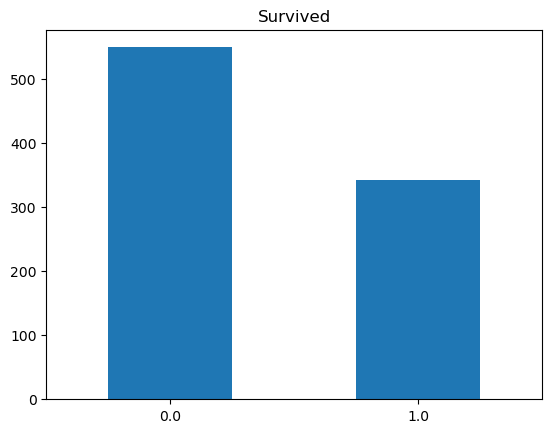

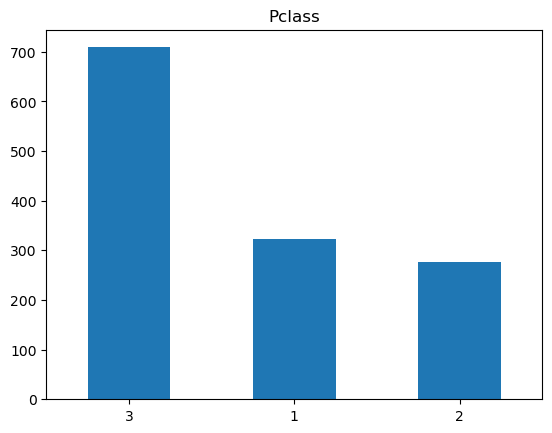

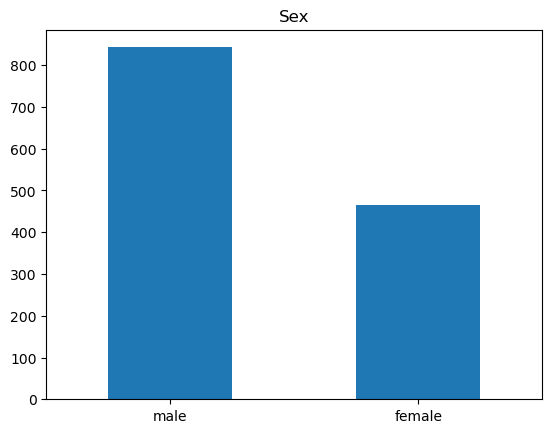

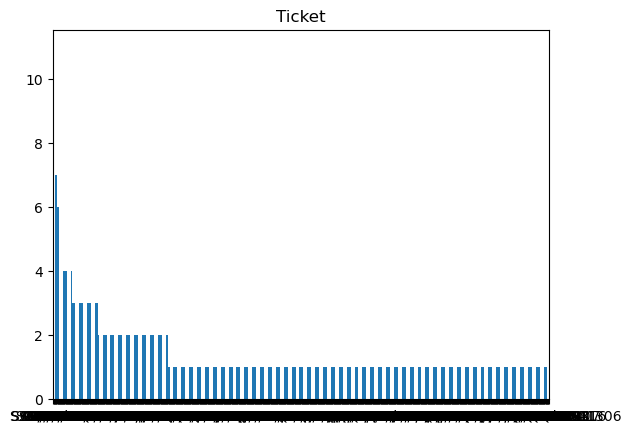

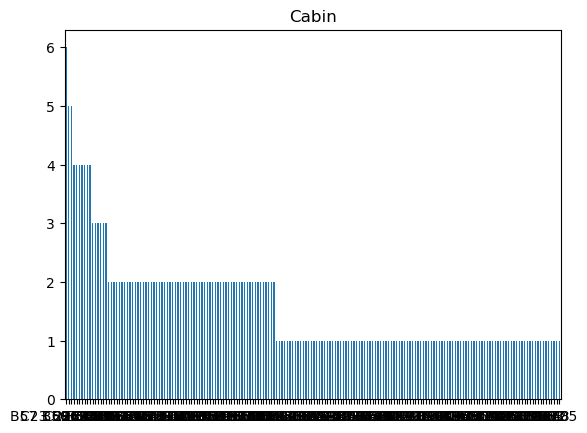

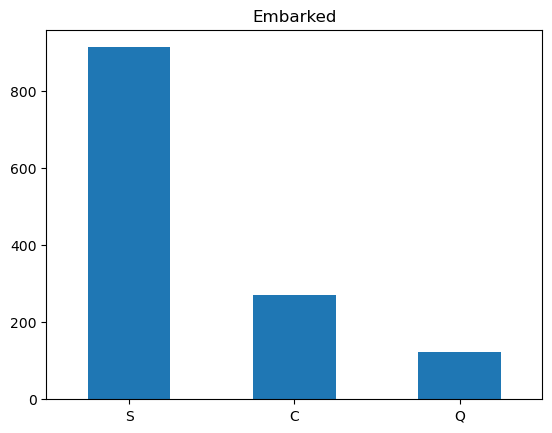

In [31]:
for i in df_cat.columns: #Choosing only the categorical data
    df_cat[i].value_counts().plot(kind='bar',rot =0)
    plt.title(i)
    plt.show()


Note there is loads of Cabin and Ticket features, so we might want to do some feature engineering

Maybe Cabin's closer to each other tended to either survive or not.

Person's title relate to survival rates??

## 3.2. Parity of Cabin Number Feature

In [32]:
#Now im going to check if even or odd cabins were more prone to surviving
def check_parity_cabins(x):
    if pd.isna(x)==True: #nan para los que no se sabe numero
        return np.nan
    elif len(x.split(' '))>1: #Algunos tienen varias cabinas(asi que miramos su primera)
        y = x.split(' ')[0][1:]
        if y.isnumeric()==False: #Miramos la segunda en caso que la primera no tenga numero
            z = x.split(' ')[1][1:]
            if int(z)%2==0:
                return '1even'
            else:
                return '1odd'
        elif int(y)%2==0:
            return '1even'
        else:
            return '1odd'
    elif x[1:].isnumeric()== True and int(x[1:])%2 == 0:
        return '1even'
    elif x.split(' ')[0][1:].isnumeric()==False:
        return np.nan
    else:
        return '1odd'
        
all_data['Cabin_last_digit'] = all_data.apply(lambda x: check_parity_cabins(x.Cabin) if x.Pclass == 1 else np.nan, axis =1)
print(pd.pivot_table(all_data, index = 'Survived', columns = 'Cabin_last_digit', values = 'Ticket' ,aggfunc ='count'))
print()

Cabin_last_digit  1even  1odd
Survived                     
0.0                  38    20
1.0                  58    59



Even numbered cabins had less survival rate.

Let's now see the cabin letters

## 3.3. Cabin Letter Feature

In [33]:
#creates categories based on the cabin letter (n stands for null)
#in this case we will treat null values like it's own category

all_data['cabin_letter'] = all_data.Cabin.apply(lambda x: "letter " + str(x)[0])


In [34]:
#comparing surivial rate by cabin
print(all_data.cabin_letter.value_counts())
pd.pivot_table(all_data,index='Survived',columns='cabin_letter', values = 'Ticket', aggfunc='count')

letter n    1014
letter C      94
letter B      65
letter D      46
letter E      41
letter A      22
letter F      21
letter G       5
letter T       1
Name: cabin_letter, dtype: int64


cabin_letter,letter A,letter B,letter C,letter D,letter E,letter F,letter G,letter T,letter n
Survived,,,,,,,,,
0.0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1.0,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


Maybe B, D y E have higher survival rates. Checking a map of the titanic, there was no cabin T, hence I am going to drop it. I am also dropping letter n, since that means we don't know the letter. I drop this values later.

Let's also see the correlation values between the cabin letter and the passenger class, because maybe one depends on the other. I do this after one hot featuring because I use the fact that I have splitted the Cabin letter feature into multiple features of the corresponding letters.

In [35]:
pd.pivot_table(all_data,index='Pclass',columns='cabin_letter', values = 'Ticket', aggfunc='count')

cabin_letter,letter A,letter B,letter C,letter D,letter E,letter F,letter G,letter T,letter n
Pclass,,,,,,,,,
1,22.0,65.0,94.0,40.0,34.0,NaN,NaN,1.0,67.0
2,NaN,NaN,NaN,6.0,4.0,13.0,NaN,NaN,254.0
3,NaN,NaN,NaN,NaN,3.0,8.0,5.0,NaN,693.0


As we can see we don't have much info on the cabin on the 2nd and 3rd class passengers, hence for them the model can't learn much about the cabin. Therefore I am going to just use the cabin letter of the first class passengers. I am going to divide the first class passenger feature into 6 features: 1letter_A, 1letter_B, 1letter_C, 1letter_D, 1letter_E and 1letter_n.

In [36]:
all_data['1letter_A'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter A' and x.Pclass==1 else 0, axis =1)
all_data['1letter_B'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter B' and x.Pclass==1 else 0, axis =1)
all_data['1letter_C'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter C' and x.Pclass==1 else 0, axis =1)
all_data['1letter_D'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter D' and x.Pclass==1 else 0, axis =1)
all_data['1letter_E'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter E' and x.Pclass==1 else 0, axis =1)
all_data['1letter_n'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter n' and x.Pclass==1 else 0, axis =1)

In [37]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(all_data, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(all_data, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(all_data, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0.0        80  97  372
1.0       136  87  119

Sex       female  male
Survived              
0.0           81   468
1.0          233   109

Embarked   C   Q    S
Survived             
0.0       75  47  427
1.0       95  30  217


# 4. One Hot Encoding Categorical Data

In [38]:
all_data.Pclass = all_data.Pclass.astype(str) #The data in passenger class is numeric but I want it in object type do that hstack works

In [39]:
ohe = OneHotEncoder()
onehottrain = ohe.fit_transform(all_data[['Pclass', 'Sex', 'name_title', 'Cabin_last_digit', 'Embarked', 'cabin_letter']]).toarray()
#fit_transform first encodes(fits) data and then transforms it from OneHotEncoder type to list
features_labels = ohe.categories_ #This is an array of arrays
print(features_labels)
features_labels1 = np.hstack(features_labels)#This is an array of objects


[array(['1', '2', '3'], dtype=object), array(['female', 'male'], dtype=object), array(['Master', 'Miss', 'Mr', 'Mrs', 'Uncommon'], dtype=object), array(['1even', '1odd', nan], dtype=object), array(['C', 'Q', 'S'], dtype=object), array(['letter A', 'letter B', 'letter C', 'letter D', 'letter E',
       'letter F', 'letter G', 'letter T', 'letter n'], dtype=object)]


Here we have the categorical features in one hot data form

In [40]:
onehotfeatures = pd.DataFrame(np.array(onehottrain), columns= features_labels1)
print(onehotfeatures)

        1    2    3  female  male  Master  Miss   Mr  Mrs  Uncommon  ...    S  \
0     0.0  0.0  1.0     0.0   1.0     0.0   0.0  1.0  0.0       0.0  ...  1.0   
1     1.0  0.0  0.0     1.0   0.0     0.0   0.0  0.0  1.0       0.0  ...  0.0   
2     0.0  0.0  1.0     1.0   0.0     0.0   1.0  0.0  0.0       0.0  ...  1.0   
3     1.0  0.0  0.0     1.0   0.0     0.0   0.0  0.0  1.0       0.0  ...  1.0   
4     0.0  0.0  1.0     0.0   1.0     0.0   0.0  1.0  0.0       0.0  ...  1.0   
...   ...  ...  ...     ...   ...     ...   ...  ...  ...       ...  ...  ...   
1304  0.0  0.0  1.0     0.0   1.0     0.0   0.0  1.0  0.0       0.0  ...  1.0   
1305  1.0  0.0  0.0     1.0   0.0     0.0   0.0  0.0  0.0       1.0  ...  0.0   
1306  0.0  0.0  1.0     0.0   1.0     0.0   0.0  1.0  0.0       0.0  ...  1.0   
1307  0.0  0.0  1.0     0.0   1.0     0.0   0.0  1.0  0.0       0.0  ...  1.0   
1308  0.0  0.0  1.0     0.0   1.0     1.0   0.0  0.0  0.0       0.0  ...  0.0   

      letter A  letter B  l

Note the Nan columns are not very informative so we should drop them

In [41]:
onehotfeatures = onehotfeatures[onehotfeatures.columns.dropna()]
onehotfeatures

,1,2,3,female,male,Master,Miss,Mr,Mrs,Uncommon,...,S,letter A,letter B,letter C,letter D,letter E,letter F,letter G,letter T,letter n
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1305,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1307,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Index(['1', '2', '3', 'female', 'male', 'Master', 'Miss', 'Mr', 'Mrs',
       'Uncommon', '1even', '1odd', 'C', 'Q', 'S', 'letter A', 'letter B',
       'letter C', 'letter D', 'letter E', 'letter F', 'letter G', 'letter T',
       'letter n'],
      dtype='object')


<AxesSubplot:>

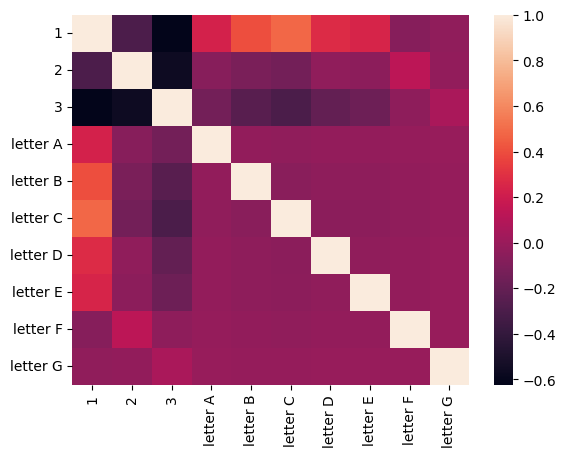

In [42]:
print(onehotfeatures.columns)
klk = onehotfeatures[['1', '2', '3', 'letter A', 'letter B', 'letter C', 'letter D', 'letter E', 'letter F', 'letter G']]
sns.heatmap(klk.corr())

From this we can see that there's a small tendency of higher classes being in the first letters of the alphabet and lower classes on the following letters. The tendency seems to be too low to drop it. I have decided to drop them for second and third passenger classes, since for these the cabin info was too low. I do this at the end of manipulating the data.

# 5. Numeric data

## 5.1. Family Size Feature

I am going to combine Sibsp and Parch into a Family size feature, this is to reduce the number of features, preventing overfitting.

In [43]:
all_data['Family_size'] = all_data.apply(lambda x: x.SibSp + x.Parch, axis =1)

## 5.2. Analysis

In [44]:
df_num = all_data[['Age','Family_size','Fare_per_passenger', 'Ticket_group_size']]

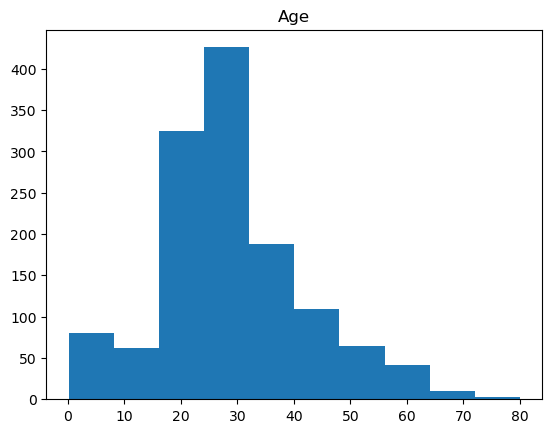

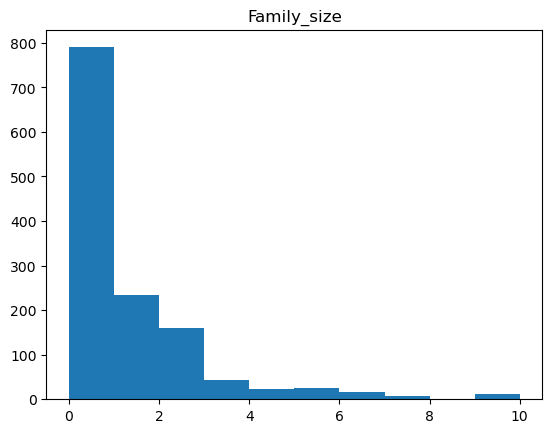

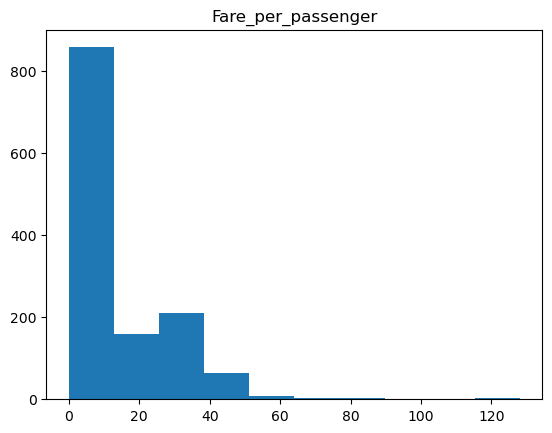

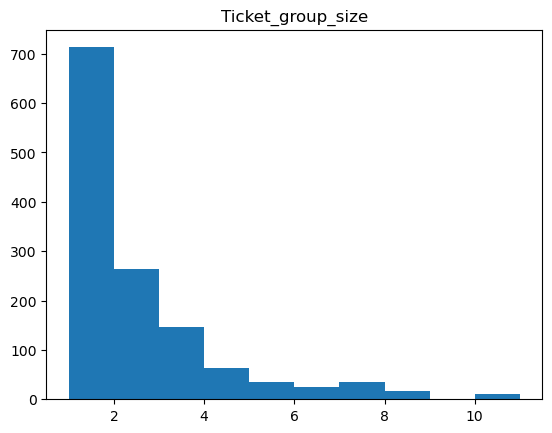

In [45]:
#distributions for all numeric variables 
for i in df_num.columns:
    plt.hist(all_data[i])
    plt.title(i)
    plt.show()

It looks like all the distributions except Age should be normalized. Also the ranges are different. Hence Fare and Age will influence more the model due to higher values.

In [46]:
print(df_num.corr()) #This gives the correlation values 

                         Age  Family_size  Fare_per_passenger  \
Age                 1.000000    -0.220098            0.346462   
Family_size        -0.220098     1.000000           -0.050028   
Fare_per_passenger  0.346462    -0.050028            1.000000   
Ticket_group_size  -0.172926     0.800556            0.094280   

                    Ticket_group_size  
Age                         -0.172926  
Family_size                  0.800556  
Fare_per_passenger           0.094280  
Ticket_group_size            1.000000  


Note that Ticket_group_size is highly correlated with Family_size and Fare_per_passenger. This should be expected, however we might want to perform some further feature engineering so that these features don't affect too much the model. 

In [47]:
# get the average Age, SibSp, Parch, and Fare for survivals and non-survivals
pd.pivot_table(all_data, index = 'Survived', values = ['Age','SibSp','Parch','Fare_per_passenger'])

,Age,Fare_per_passenger,Parch,SibSp
Survived,,,,
0.0,30.636612,11.463456,0.329690,0.553734
1.0,28.303129,19.507553,0.464912,0.473684


## 5.3. Normalizing

Now we log normalize the Fare_per_passenger, Family_size and Ticket_group_size.

<AxesSubplot:>

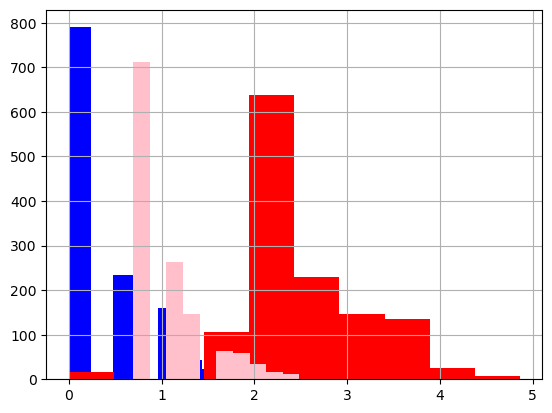

In [48]:
all_data['norm_family'] = np.log(all_data.Family_size+1)
all_data['norm_family'].hist(color = 'blue')

all_data['norm_fare_per_passenger'] = np.log(all_data.Fare_per_passenger+1)
all_data['norm_fare_per_passenger'].hist(color = 'red')

all_data['norm_ticketgroup'] = np.log(all_data.Ticket_group_size+1)
all_data['norm_ticketgroup'].hist(color = 'pink')


We can see that the fare per passenger has been kind of normalized, therefore the orginal fare per passenger was log normal distributed. 

## 5.4. Age featuring

I first took age as a numeric variable. However it makes sense that children survived more than adults. Let's divide the age into 4 catgories 0-20, 21-40, 41-60,61+.

In [49]:
all_data['Age1'] = all_data.Age.apply(lambda x: 1 if x<= 20 else 0)
all_data['Age2'] = all_data.Age.apply(lambda x: 1 if x> 20 and x<=40 else 0)
all_data['Age3'] = all_data.Age.apply(lambda x: 1 if x>40 and x<= 60 else 0)
all_data['Age4'] = all_data.Age.apply(lambda x: 1 if x>60 else 0)

In [50]:
#Create DataFrames with only individuals of each age category
Age1df = all_data[all_data.Age1==1]
Age2df = all_data[all_data.Age2==1]
Age3df = all_data[all_data.Age3==1]
Age4df = all_data[all_data.Age4==1]
print('Age1 rates: ', Age1df['Survived'].value_counts(normalize = True))
print()
print('Age2 rates: ', Age2df['Survived'].value_counts(normalize = True))
print()
print('Age3 rates: ', Age3df['Survived'].value_counts(normalize = True))
print()
print('Age4 rates: ', Age4df['Survived'].value_counts(normalize = True))

Age1 rates:  0.0    0.540984
1.0    0.459016
Name: Survived, dtype: float64

Age2 rates:  0.0    0.635548
1.0    0.364452
Name: Survived, dtype: float64

Age3 rates:  0.0    0.612403
1.0    0.387597
Name: Survived, dtype: float64

Age4 rates:  0.0    0.772727
1.0    0.227273
Name: Survived, dtype: float64


Clearly Age1 survived the most, Age2 and Age3 are similar and Age4 survived the least.

In [51]:
Agedf = all_data[dtrain.Age==2]
print(Agedf['Survived'].value_counts(normalize = True))
Agedf['Survived'].value_counts(normalize = True).keys()

0.0    0.7
1.0    0.3
Name: Survived, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Float64Index([0.0, 1.0], dtype='float64')

In [52]:
Dict = {}
for i in range(1,90):
    Agedf = dtrain[dtrain.Age==i]
    if len(Agedf.index)==0:
        continue
    x = Agedf['Survived'].value_counts(normalize = True)
    ind = Agedf['Survived'].value_counts(normalize = True).index
    for j in ind:
        if j==1:
            Dict[i]=x[j]
        else:
            Dict[i]=1-x[j]
print(Dict)

{1: 0.7142857142857143, 2: 0.3, 3: 0.8333333333333334, 4: 0.7, 5: 1.0, 6: 0.6666666666666667, 7: 0.3333333333333333, 8: 0.5, 9: 0.25, 10: 0.0, 11: 0.25, 12: 1.0, 13: 1.0, 14: 0.5, 15: 0.8, 16: 0.35294117647058826, 17: 0.46153846153846156, 18: 0.34615384615384615, 19: 0.36, 20: 0.2, 21: 0.20833333333333334, 22: 0.4074074074074074, 23: 0.3333333333333333, 24: 0.5, 25: 0.2608695652173913, 26: 0.3333333333333333, 27: 0.6111111111111112, 28: 0.28, 29: 0.4, 30: 0.4, 31: 0.47058823529411764, 32: 0.5, 33: 0.4, 34: 0.4, 35: 0.6111111111111112, 36: 0.5, 37: 0.16666666666666666, 38: 0.45454545454545453, 39: 0.35714285714285715, 40: 0.46153846153846156, 41: 0.3333333333333333, 42: 0.46153846153846156, 43: 0.2, 44: 0.3333333333333333, 45: 0.4166666666666667, 46: 0.0, 47: 0.1111111111111111, 48: 0.6666666666666667, 49: 0.6666666666666667, 50: 0.5, 51: 0.2857142857142857, 52: 0.5, 53: 1.0, 54: 0.375, 55: 0.5, 56: 0.5, 57: 0.0, 58: 0.6, 59: 0.0, 60: 0.5, 61: 0.0, 62: 0.5, 63: 1.0, 64: 0.0, 65: 0.0, 66

In [53]:
List0 = []
for i in list(Dict):
    List0.append(Dict[i])

Text(0.5, 1.0, 'Survival rate by age')

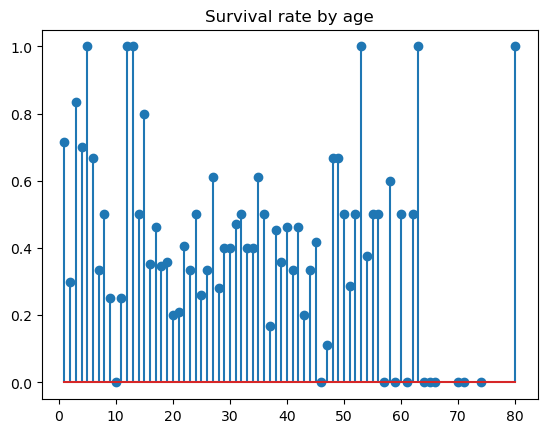

In [54]:
plt.stem(Dict.keys(),Dict.values())
plt.title('Survival rate by age')

From this plot we can see that ages from 0 to 15 survived more. Also ages from 48 to 80 survived more. Let's see if there is a difference in the plots for men and women. 

In [55]:
DictMen = {}
for i in range(1,90):
    Agedf = dtrain[dtrain.Age==i]
    AgeMendf = Agedf[Agedf.Sex == 'male']
    if len(AgeMendf.index)==0:
        continue
    x = AgeMendf['Survived'].value_counts(normalize = True)
    ind = AgeMendf['Survived'].value_counts(normalize = True).index
    for j in ind:
        if j==1:
            DictMen[i]=x[j]
        else:
            DictMen[i]=1-x[j]
print(DictMen)

{1: 0.6, 2: 0.25, 3: 1.0, 4: 0.4, 6: 1.0, 7: 0.0, 8: 0.5, 9: 0.5, 10: 0.0, 11: 0.3333333333333333, 12: 1.0, 14: 0.0, 15: 0.0, 16: 0.09090909090909091, 17: 0.14285714285714285, 18: 0.07692307692307693, 19: 0.1111111111111111, 20: 0.23076923076923078, 21: 0.058823529411764705, 22: 0.06666666666666667, 23: 0.1, 24: 0.07142857142857142, 25: 0.2222222222222222, 26: 0.23076923076923078, 27: 0.5, 28: 0.1111111111111111, 29: 0.23076923076923078, 30: 0.07142857142857142, 31: 0.3, 32: 0.4666666666666667, 33: 0.0, 34: 0.18181818181818182, 35: 0.3, 36: 0.26666666666666666, 37: 0.2, 38: 0.16666666666666666, 39: 0.125, 40: 0.14285714285714285, 41: 0.0, 42: 0.3, 43: 0.0, 44: 0.16666666666666666, 45: 0.3333333333333333, 46: 0.0, 47: 0.0, 48: 0.6, 49: 0.5, 50: 0.2, 51: 0.16666666666666666, 52: 0.25, 54: 0.0, 55: 0.0, 56: 0.3333333333333333, 57: 0.0, 58: 0.0, 59: 0.0, 60: 0.3333333333333333, 61: 0.0, 62: 0.3333333333333333, 64: 0.0, 65: 0.0, 66: 0.0, 70: 0.0, 71: 0.0, 74: 0.0, 80: 1.0}


In [56]:
DictWM = {}
for i in range(1,90):
    Agedf = dtrain[dtrain.Age==i]
    AgeWMdf = Agedf[Agedf.Sex == 'female']
    if len(AgeWMdf.index)==0:
        continue
    x = AgeWMdf['Survived'].value_counts(normalize = True)
    ind = AgeWMdf['Survived'].value_counts(normalize = True).index
    for j in ind:
        if j==1:
            DictWM[i]=x[j]
        else:
            DictWM[i]=1-x[j]
print(DictWM)

{1: 1.0, 2: 0.3333333333333333, 3: 0.5, 4: 1.0, 5: 1.0, 6: 0.5, 7: 1.0, 8: 0.5, 9: 0.0, 10: 0.0, 11: 0.0, 13: 1.0, 14: 0.75, 15: 1.0, 16: 0.8333333333333334, 17: 0.8333333333333334, 18: 0.6153846153846154, 19: 1.0, 20: 0.0, 21: 0.5714285714285714, 22: 0.8333333333333334, 23: 0.8, 24: 0.875, 25: 0.4, 26: 0.6, 27: 0.8333333333333334, 28: 0.7142857142857143, 29: 0.7142857142857143, 30: 0.8181818181818181, 31: 0.7142857142857143, 32: 0.6666666666666667, 33: 1.0, 34: 1.0, 35: 1.0, 36: 1.0, 37: 0.0, 38: 0.8, 39: 0.6666666666666667, 40: 0.8333333333333334, 41: 0.5, 42: 1.0, 43: 0.5, 44: 0.6666666666666667, 45: 0.5, 47: 0.5, 48: 0.75, 49: 1.0, 50: 0.8, 51: 1.0, 52: 1.0, 53: 1.0, 54: 1.0, 55: 1.0, 56: 1.0, 57: 0.0, 58: 1.0, 60: 1.0, 62: 1.0, 63: 1.0}


Text(0.5, 1.0, 'Men survival rate by age')

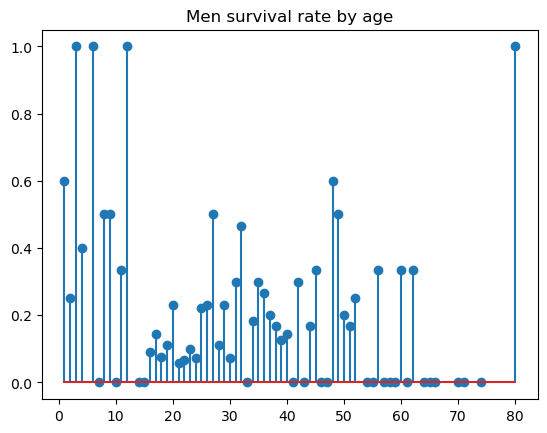

In [57]:
plt.stem(DictMen.keys(),DictMen.values())
plt.title('Men survival rate by age')

Text(0.5, 1.0, 'Women survival rate by age')

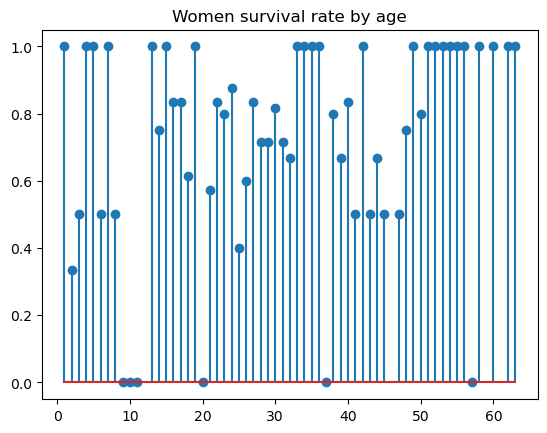

In [58]:
plt.stem(DictWM.keys(),DictWM.values())
plt.title('Women survival rate by age')

From these 2 plots we can see that the ages seem to affect differently the survival rates in men and women. 

We can divide Men into two age categories: 0-13,14+.

Women can be divided into three age categories: 0-18, 19-48,48+.


In [59]:
all_data['Boys'] = all_data.apply(lambda x: 1 if x.Age <= 13 and x.Sex == 'male' else 0, axis = 1)
all_data['Men'] = all_data.apply(lambda x: 1 if x.Age > 13 and x.Sex == 'male' else 0, axis = 1)
all_data['Girls'] = all_data.apply(lambda x: 1 if x.Age <= 18 and x.Sex == 'female' else 0, axis = 1)
all_data['Women0'] = all_data.apply(lambda x: 1 if 19 <= x.Age <= 48 and x.Sex == 'female' else 0, axis = 1)
all_data['Women1'] = all_data.apply(lambda x: 1 if x.Age >= 49 and x.Sex == 'female' else 0, axis = 1)


Im going to group boys and girls into a kids feature, to reduce number of features and prevent overfitting.

In [60]:
all_data['Kids'] = all_data.apply(lambda x: 1 if x.Boys==1 and x.Girls==1 else 0, axis=1)

# 6. Preparing training data and test data

There are several validation techniques used to evaluate the performance of a machine learning model on unseen data. Here are some of the most common ones:

1) Holdout validation: In this technique, the data is randomly split into two sets, a training set and a validation set. The model is trained on the training set and evaluated on the validation set. Holdout validation is simple to implement, but it can be sensitive to the random seed used to split the data and may not be representative of the overall performance of the model.

2) K-fold cross-validation: This technique involves dividing the data into K equally-sized folds, where K is typically set to 5 or 10. The model is trained on K-1 folds and evaluated on the remaining fold. This process is repeated K times, with each fold serving as the validation set exactly once. The performance of the model is then averaged across all K folds.

3) Leave-one-out cross-validation: This is a special case of K-fold cross-validation where K is equal to the number of samples in the dataset. In each iteration, the model is trained on all but one sample and evaluated on the left-out sample.

4) Stratified sampling: This technique is used when the dataset is imbalanced or the target variable has multiple classes. In stratified sampling, the data is divided into subsets based on the target variable, ensuring that each subset has a similar distribution of classes. The model is then trained and evaluated on each subset.

5) Bootstrapping: In bootstrapping, multiple samples of the dataset are created by randomly sampling with replacement. The model is trained on each sample and evaluated on the original dataset. The performance of the model is then averaged across all samples.

K-fold cross-validation is a technique used to evaluate the performance of a machine learning model on a dataset. In K-fold cross-validation, the dataset is divided into K subsets or "folds" of equal size. The model is trained on K-1 folds of the data and evaluated on the remaining fold. This process is repeated K times, with each fold serving as the test set exactly once.

At the end of the K iterations, the performance metric (such as accuracy, F1-score, or mean squared error) is averaged across all K folds to obtain a single performance estimate for the model.

K-fold cross-validation is often used to estimate the performance of a model and to compare different models. It can also be used to tune hyperparameters of a model, such as the regularization strength, learning rate, or the number of hidden layers in a neural network. By using K-fold cross-validation, the model is trained and evaluated on different subsets of the data, which can help to reduce the variance of the performance estimate and provide a more robust evaluation of the model's performance.

In this notebook I use Holdout crosss-validation, using the test and training sets given. In the next section I train the models using the training set and give a cross validation score using the test set. However one could use any of the methods mentioned above.

We now have all the data as we want it.

In [61]:
print(onehotfeatures.columns)
print(all_data.columns)

Index(['1', '2', '3', 'female', 'male', 'Master', 'Miss', 'Mr', 'Mrs',
       'Uncommon', '1even', '1odd', 'C', 'Q', 'S', 'letter A', 'letter B',
       'letter C', 'letter D', 'letter E', 'letter F', 'letter G', 'letter T',
       'letter n'],
      dtype='object')
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test',
       'name_title', 'Ticket_group_size', 'Fare_per_passenger',
       'Cabin_last_digit', 'cabin_letter', '1letter_A', '1letter_B',
       '1letter_C', '1letter_D', '1letter_E', '1letter_n', 'Family_size',
       'norm_family', 'norm_fare_per_passenger', 'norm_ticketgroup', 'Age1',
       'Age2', 'Age3', 'Age4', 'Boys', 'Men', 'Girls', 'Women0', 'Women1',
       'Kids'],
      dtype='object')


Let's drop the columns we don't want any more (due to feature engineering or one hot encoding)

In [62]:
all_data0 = all_data.drop(['PassengerId', 'Pclass', 'Name', 'Sex', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'cabin_letter', 'name_title', 'Cabin_last_digit', 'norm_ticketgroup', 'norm_fare_per_passenger', 'Age', 'Age1', 'Age2', 'Age3', 'Age4', 'SibSp', 'Parch', 'Boys', 'Girls'], axis=1)
onehotfeatures0 = onehotfeatures.drop(['male', 'female', 'letter A', 'letter B', 'letter C', 'letter D', 'letter E', 'letter F', 'letter G', 'letter T', 'letter n', '1'], axis=1)
print(all_data0.columns)
print(onehotfeatures0.columns)

Index(['Survived', 'train_test', 'Ticket_group_size', 'Fare_per_passenger',
       '1letter_A', '1letter_B', '1letter_C', '1letter_D', '1letter_E',
       '1letter_n', 'Family_size', 'norm_family', 'Men', 'Women0', 'Women1',
       'Kids'],
      dtype='object')
Index(['2', '3', 'Master', 'Miss', 'Mr', 'Mrs', 'Uncommon', '1even', '1odd',
       'C', 'Q', 'S'],
      dtype='object')


In [63]:
all_data1 = all_data0.reset_index() #This removes an indexing error by cretaing an index column, we will later remove this column to prevent overfitting
print(all_data1.columns)
all_data2 = pd.concat([onehotfeatures0, all_data1], axis=1)

all_data2 = all_data2.drop(['index'], axis = 1)
all_data2.columns

Index(['index', 'Survived', 'train_test', 'Ticket_group_size',
       'Fare_per_passenger', '1letter_A', '1letter_B', '1letter_C',
       '1letter_D', '1letter_E', '1letter_n', 'Family_size', 'norm_family',
       'Men', 'Women0', 'Women1', 'Kids'],
      dtype='object')


Index(['2', '3', 'Master', 'Miss', 'Mr', 'Mrs', 'Uncommon', '1even', '1odd',
       'C', 'Q', 'S', 'Survived', 'train_test', 'Ticket_group_size',
       'Fare_per_passenger', '1letter_A', '1letter_B', '1letter_C',
       '1letter_D', '1letter_E', '1letter_n', 'Family_size', 'norm_family',
       'Men', 'Women0', 'Women1', 'Kids'],
      dtype='object')

In [64]:
#Split to train test again
X_train = all_data2[all_data2.train_test == 1].drop(['train_test', 'Survived'], axis =1)
X_test = all_data2[all_data2.train_test == 0].drop(['train_test', 'Survived'], axis =1)


y_train = all_data2[all_data2.train_test==1].Survived

Now we scale data

In [65]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_data_scaled = all_data2.copy()
all_data_scaled[['Family_size','Fare_per_passenger']]= scale.fit_transform(all_data_scaled[['Family_size','Fare_per_passenger']])


X_train_scaled = all_data_scaled[all_data_scaled.train_test == 1].drop(['train_test','Survived'], axis =1)
X_test_scaled = all_data_scaled[all_data_scaled.train_test == 0].drop(['train_test', 'Survived'], axis =1)

y_train0 = all_data_scaled[all_data_scaled.train_test==1].Survived


In [66]:
print(all_data_scaled.columns)

Index(['2', '3', 'Master', 'Miss', 'Mr', 'Mrs', 'Uncommon', '1even', '1odd',
       'C', 'Q', 'S', 'Survived', 'train_test', 'Ticket_group_size',
       'Fare_per_passenger', '1letter_A', '1letter_B', '1letter_C',
       '1letter_D', '1letter_E', '1letter_n', 'Family_size', 'norm_family',
       'Men', 'Women0', 'Women1', 'Kids'],
      dtype='object')


Now im going to split the training set into 90% training set and 10% validation set. 

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
# Split the train and the validation set for the fitting
X_train_scaled, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train0, test_size = 0.1, random_state=2)

# 7. Model Building

Note that we don't need scaled features for Decision Trees, Random Forest or XGBoost. For logistic regression (and nural networks) there is a regularization parameter $\lambda$ that takes care of non-scaled features. For the rest, it should improve accuracy when scaling. For example, KNN and SVC are both classifiers that use distances of points on space to create the loss function. These distances can be highly unbalanced if data is not scaled, making the model reduce or increase unreasonably the importance of certain features.

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [70]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cvGNB1 = cross_val_score(gnb,X_train,y_train0,cv=5)
print(cvGNB1)
print(cvGNB1.mean())

[0.68156425 0.76966292 0.7752809  0.78089888 0.82022472]
0.7655263323080785


In [71]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cvGNB2 = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cvGNB2)
print(cvGNB2.mean())

[0.77639752 0.7875     0.8        0.78125    0.75625   ]
0.7802795031055901


In [72]:
gnbarr= np.array([cvGNB1.mean(), cvGNB2.mean()])

In [73]:
lr = LogisticRegression(max_iter = 2000)
cvlr1 = cross_val_score(lr,X_train,y_train0,cv=5)
print(cvlr1)
print(cvlr1.mean())


[0.82122905 0.8258427  0.80898876 0.8258427  0.87640449]
0.8316615403929445


In [74]:
lr = LogisticRegression(max_iter = 2000)
cvlr2 = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cvlr2)
print(cvlr2.mean())

[0.82608696 0.85       0.85       0.80625    0.81875   ]
0.8302173913043477


In [75]:
lrarr= np.array([cvlr1.mean(), cvlr2.mean()])

In [76]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cvdt1 = cross_val_score(dt,X_train,y_train0,cv=5)
print(cvdt1)
print(cvdt1.mean())

[0.79329609 0.76966292 0.8258427  0.82022472 0.80898876]
0.8036030381018142


In [77]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cvdt2 = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cvdt2)
print(cvdt2.mean())

[0.76397516 0.85       0.8125     0.80625    0.7625    ]
0.7990450310559005


In [78]:
dtarr= np.array([cvdt1.mean(), cvdt2.mean()])

In [79]:
knn = KNeighborsClassifier()
cvknn1 = cross_val_score(knn,X_train,y_train0,cv=5)
print(cvknn1)
print(cvknn1.mean())

[0.77094972 0.76966292 0.83707865 0.82022472 0.83707865]
0.8069989328981231


In [80]:
knn = KNeighborsClassifier()
cvknn2 = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cvknn2)
print(cvknn2.mean())

[0.80745342 0.83125    0.8125     0.79375    0.8       ]
0.8089906832298137


In [81]:
knnarr= np.array([cvknn1.mean(), cvknn2.mean()])

In [82]:
rf = RandomForestClassifier(random_state = 1)
cvrf1 = cross_val_score(rf,X_train,y_train0,cv=5)
print(cvrf1)
print(cvrf1.mean())

[0.7877095  0.78651685 0.83707865 0.80898876 0.84269663]
0.8125980792166217


In [83]:
rf = RandomForestClassifier(random_state = 1)
cvrf2 = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cvrf2)
print(cvrf2.mean())

[0.7826087 0.8375    0.81875   0.81875   0.79375  ]
0.8102717391304347


In [84]:
rfarr= np.array([cvrf1.mean(), cvrf2.mean()])

In [85]:
svc = SVC(probability = True)
cvsvc2 = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cvsvc2)
print(cvsvc2.mean())

[0.80745342 0.85625    0.85       0.85       0.8125    ]
0.8352406832298136


In [86]:
svc = SVC(probability = True)
cvsvc1 = cross_val_score(svc,X_train,y_train0,cv=5)
print(cvsvc1)
print(cvsvc1.mean())

[0.63128492 0.73595506 0.70786517 0.80337079 0.7752809 ]
0.7307513652626954


In [87]:
svcarr= np.array([cvsvc1.mean(), cvsvc2.mean()])

In [88]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cvxgb2 = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cvxgb2)
print(cvxgb2.mean())

[0.79503106 0.84375    0.84375    0.8125     0.7875    ]
0.8165062111801241


In [89]:
cvxgb1 = cross_val_score(xgb,X_train,y_train0,cv=5)
print(cvxgb1)
print(cvxgb1.mean())

[0.82681564 0.78651685 0.86516854 0.82022472 0.84269663]
0.8282844768062269


In [90]:
xgbarr= np.array([cvxgb1.mean(), cvxgb2.mean()])

In [91]:
Arraymodels= np.array([gnbarr, lrarr, dtarr, knnarr, rfarr, svcarr, xgbarr])
Arraymodels = Arraymodels.transpose()
pd.DataFrame(Arraymodels, columns = ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'K-nearest Neighbor', 'Random Forest', 'Support Vector Classifier', 'Xtreme Gradient Boosting'], index =['Non-scaled','Scaled'])

,Naive Bayes,Logistic Regression,Decision Tree,K-nearest Neighbor,Random Forest,Support Vector Classifier,Xtreme Gradient Boosting
Non-scaled,0.765526,0.831662,0.803603,0.806999,0.812598,0.730751,0.828284
Scaled,0.780280,0.830217,0.799045,0.808991,0.810272,0.835241,0.816506


In [92]:
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [93]:
cvvoting = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cvvoting)
print(cvvoting.mean())

[0.83229814 0.83125    0.85625    0.8375     0.79375   ]
0.8302096273291925


**The best is Support vector classifier when features are scaled**

I will output one cv file with the prediction of the xgb.

In [94]:
xgb.fit(X_train_scaled,y_train)
y_hat_base_vc = xgb.predict(X_test_scaled).astype(int)
basic_submission = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_base_vc}
xgb_submission = pd.DataFrame(data=basic_submission)
xgb_submission.to_csv('submission.csv', index=False)


# 8. Hyperparameter Tuning (Here I only use XGB, SVC and KNN)

When tuning models it is usually preferred to divide the data into: 
<ol>
  <li>Training set (For training model) </li> 
  <li>Validation set (For tuning parameters) </li> 
  <li>Test set (For getting a cv is score of tuned model) </li> 
</ol>
There is several methods to divide the data and tune the parameters:
<ol>
    <li>Hold-out (Simple one)</li>
    <li>K-folds</li>
    <li>Leave-one-out</li>
    <li>Leave-p-out</li>
    <li>Stratified K-folds</li>
    <li>Repeated K-folds</li>
    <li>Nested K-folds</li>
    <li>Time series CV</li>

## 8.1. Randomized Search Tuning

In [95]:
from sklearn.model_selection import RandomizedSearchCV 

In [96]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [97]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : list(range(1,12)),
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree', 'brute'],
              'p' : [1,2]}
clf_knn = RandomizedSearchCV(knn, param_distributions = param_grid, n_iter = 5, cv = 3, scoring = 'accuracy')
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

KNN
Best Score: 0.8102372034956304
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'algorithm': 'auto'}


In [98]:
y_hat_knn0 = best_clf_knn.best_estimator_.predict(X_test_scaled).astype(int)
knn_submission0 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_knn0}
submission_knn0 = pd.DataFrame(data=knn_submission0)
submission_knn0.to_csv('knnrand_submission3.csv', index=False)

In [115]:
for i in range(10):
    svc = SVC(probability = True)
    param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': list(np.arange(1,100, 0.1))},
                                 {'kernel': ['linear'], 'C': list(np.arange(1,100, 0.1))},
                                 {'kernel': ['poly'], 'degree' : [2,3,4], 'C': list(np.arange(1,100,0.1)), 'gamma':[.1,.5,1,2,5,10]},
                                {'kernel': ['sigmoid'], 'C': list(np.arange(1,100, 0.1)), }]
    clf_svc = RandomizedSearchCV(svc, param_distributions = param_grid, n_iter = 5, cv = 3, scoring = 'accuracy')
    best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
    clf_performance(best_clf_svc,'SVC')


KeyboardInterrupt: 

Linear and sigmoid kernels have not been chosen, so when doing grid search i will use them. The degree is best between 2 and 3. And the inversed regularization parameter C varies between 1-75. 

In [ ]:
y_hat_svc0 = best_clf_svc.best_estimator_.predict(X_test_scaled).astype(int)
svc_submission0 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_svc0}
submission_svc0 = pd.DataFrame(data=svc_submission0)
submission_svc0.to_csv('svcrand_submission3.csv', index=False)

In [100]:
for i in range(10):
    xgb = XGBClassifier(random_state = 1)
    param_grid = {'learning_rate':[0.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
    'gamma':[0,0.01,0.1,1,10,100],
    'max_depth': [2, 5, 10, 15, 20, 25],
    'min_child_weight':[0,0.01,0.1,1,10,100],
    'subsample': [0.5,0.6,0.7, 0.8, 0.9],
    'sampling_method': ['uniform'],
    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
    'colsample_bylevel': [0.2, 0.5, 0.7, 0.8, 1],
    'colsample_bynode': [0.2, 0.5, 0.7, 0.8, 1],
    'reg_lambda': [1, 1.5, 2],
    'reg_alpha': [1, 1.5, 2],
    'n_estimators': [20, 50, 100, 250, 500,1000],}
    #I don't use max_delta_step since class is not inbalanced
    clf_xgb = RandomizedSearchCV(xgb, param_distributions = param_grid, cv = 5, n_iter=5,scoring='accuracy')
    best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
    clf_performance(best_clf_xgb,'XGB')

XGB
Best Score: 0.8290139751552795
Best Parameters: {'subsample': 0.7, 'sampling_method': 'uniform', 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 50, 'min_child_weight': 0.01, 'max_depth': 25, 'learning_rate': 0.5, 'gamma': 10, 'colsample_bytree': 0.5, 'colsample_bynode': 1, 'colsample_bylevel': 0.5}
XGB
Best Score: 0.8339906832298137
Best Parameters: {'subsample': 0.5, 'sampling_method': 'uniform', 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 20, 'min_child_weight': 0, 'max_depth': 2, 'learning_rate': 0.01, 'gamma': 10, 'colsample_bytree': 0.5, 'colsample_bynode': 1, 'colsample_bylevel': 1}
XGB
Best Score: 0.8289518633540374
Best Parameters: {'subsample': 0.8, 'sampling_method': 'uniform', 'reg_lambda': 2, 'reg_alpha': 2, 'n_estimators': 250, 'min_child_weight': 0.01, 'max_depth': 2, 'learning_rate': 0.5, 'gamma': 0.01, 'colsample_bytree': 0.5, 'colsample_bynode': 0.5, 'colsample_bylevel': 0.7}
XGB
Best Score: 0.8240062111801242
Best Parameters: {'subsample': 0.9, 'samplin

In [101]:
y_hat_xgb0 = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
xgb_submission0 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_xgb0}
submission_xgb0 = pd.DataFrame(data=xgb_submission0)
submission_xgb0.to_csv('xgbrand_submission3.csv', index=False)

## 8.2. Grid Search Tuning

In [102]:
from sklearn.model_selection import GridSearchCV 

In [103]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8214829192546584
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [104]:
y_hat_knngrid = best_clf_knn.best_estimator_.predict(X_test_scaled).astype(int)
knn_submissiongrid = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_knngrid}
submission_knngrid = pd.DataFrame(data=knn_submissiongrid)
submission_knngrid.to_csv('knngrid_submission3.csv', index=False)

In [105]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,1,5,10],
                                  'C': [0.1, 1, 10, 100]},
                                 {'kernel': ['poly'], 'degree' : [2,3], 'C': [.1, 1, 10, 100]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVC
Best Score: 0.836498447204969
Best Parameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}


In [106]:
y_hat_svcgrid = best_clf_svc.best_estimator_.predict(X_test_scaled).astype(int)
svc_submissiongrid = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_svcgrid}
submission_svcgrid = pd.DataFrame(data=svc_submissiongrid)
submission_svcgrid.to_csv('svcgrid_submission3.csv', index=False)

In [107]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'learning_rate':[0.5,0.7],
    'gamma':[0.01,0.1,10],
    'max_depth': [25],
    'min_child_weight':[0,0.01],
    'subsample': [0.5,0.8],
    'sampling_method': ['uniform'],
    'colsample_bytree': [1],
    'reg_lambda': [1.5, 2],
    'reg_alpha': [1],
    'n_estimators': [20,40],}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 96 candidates, totalling 480 fits
XGB
Best Score: 0.8377251552795031
Best Parameters: {'colsample_bytree': 1, 'gamma': 0.01, 'learning_rate': 0.5, 'max_depth': 25, 'min_child_weight': 0, 'n_estimators': 20, 'reg_alpha': 1, 'reg_lambda': 1.5, 'sampling_method': 'uniform', 'subsample': 0.5}


In [108]:
y_hat_xgbgrid = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
xgb_submissiongrid = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_xgbgrid}
submission_xgbgrid = pd.DataFrame(data=xgb_submissiongrid)
submission_xgbgrid.to_csv('xgbgrid_submission3.csv', index=False)

## 8.3. Bayes Search Tuning

Tuning and finding the right hyperparameters for your model is an optimization problem. We want to minimize the loss function of our model by changing model parameters. Bayesian optimization helps us find the minimal point in the minimum number of steps. Bayesian optimization also uses an acquisition function that directs sampling to areas where an improvement over the current best observation is likely.

In [109]:
from skopt import BayesSearchCV

In [111]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : list(range(1,12)),
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree', 'brute'],
              'p' : [1,2]}
clf_knn = BayesSearchCV(knn, search_spaces = param_grid, n_iter = 5, cv = 5, scoring = 'accuracy')
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

KNN
Best Score: 0.8064918851435706
Best Parameters: OrderedDict([('algorithm', 'kd_tree'), ('n_neighbors', 3), ('p', 2), ('weights', 'distance')])


In [114]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': list(np.arange(1,100, 0.1))},
                                 {'kernel': ['linear'], 'C': list(np.arange(1,100, 0.1))},
                                 {'kernel': ['poly'], 'degree' : [2,3,4], 'C': list(np.arange(1,100,0.1)), 'gamma':[.1,.5,1,2,5,10]},
                                {'kernel': ['sigmoid'], 'C': list(np.arange(1,100, 0.1)), }]
clf_svc = BayesSearchCV(svc, search_spaces = param_grid, n_iter=5, cv = 5, scoring='accuracy')
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

KeyboardInterrupt: 

In [113]:
xgb = XGBClassifier(random_state = 1)
param_grid = {'learning_rate':[0.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
    'gamma':[0,0.01,0.1,1,10,100],
    'max_depth': [2, 5, 10, 15, 20, 25],
    'min_child_weight':[0,0.01,0.1,1,10,100],
    'subsample': [0.5,0.6,0.7, 0.8, 0.9],
    'sampling_method': ['uniform'],
    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
    'colsample_bylevel': [0.2, 0.5, 0.7, 0.8, 1],
    'colsample_bynode': [0.2, 0.5, 0.7, 0.8, 1],
    'reg_lambda': [1, 1.5, 2],
    'reg_alpha': [1, 1.5, 2],
    'n_estimators': [20, 50, 100, 250, 500,1000],}
    #I don't use max_delta_step since class is not inbalanced
clf_xgb = BayesSearchCV(xgb, search_spaces = param_grid, cv = 5, verbose = True, n_iter=5, scoring='accuracy')
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
XGB
Best Score: 0.8277251552795033
Best Parameters: OrderedDict([('colsample_bylevel', 0.8), ('colsample_bynode', 0.7), ('colsample_bytree', 0.8), ('gamma', 1.0), ('learning_rate', 0.3), ('max_depth', 5), ('min_child_weight', 0.01), ('n_estimators', 250), ('reg_alpha', 1.5), ('reg_lambda', 2.0), ('sampling_method', 'uniform'), ('subsample', 0.8)])


**There are some algorithms developed for doing autotuning, such as:**
<ul>
    <li>Hyperband</li>
    <li>Population-Based Training (PBT)</li>
    <li>Bayesian Optimization and HyperBand (BOHB)</li>
</ul>
I will not use them here, however for future projects I will consider them.

# 9. Ensembles using a Voting Classifier

In [ ]:
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_xgb = best_clf_xgb.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('xgb',best_knn),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('xgb',best_xgb),('svc',best_svc)], voting = 'soft') 
voting_clf_knnsoft = VotingClassifier(estimators = [('knn',best_knn),('svc',best_svc), ('xgb', best_xgb)], voting = 'soft')

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean())

print('voting_clf_knn :',cross_val_score(voting_clf_knnsoft,X_train,y_train,cv=5))
print('voting_clf_knn mean :',cross_val_score(voting_clf_knnsoft,X_train,y_train,cv=5).mean())


In [ ]:
#Make Predictions 
voting_clf_hard.fit(X_train_scaled, y_train)
voting_clf_soft.fit(X_train_scaled, y_train)
voting_clf_knnsoft.fit(X_train_scaled, y_train)

y_hat_vc_hard = voting_clf_hard.predict(X_test_scaled).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test_scaled).astype(int)
y_hat_vc_knnsoft = voting_clf_knnsoft.predict(X_test_scaled).astype(int)

In [ ]:
#convert output to dataframe 

final_data_2 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_vc_hard}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_vc_soft}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_5 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_vc_knnsoft}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'PassengerId': dtest.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_vc_soft' : y_hat_vc_soft,  'Survived_vc_xgb' : y_hat_vc_knnsoft}
comparison = pd.DataFrame(data=final_data_comp)

In [ ]:
#prepare submission files 
submission_2.to_csv('submission_vc_hard.csv',index=False)
submission_3.to_csv('submission_vc_soft.csv', index=False)
submission_5.to_csv('submission_vc_knn.csv', index=False)

# 10. Evaluation metrics

A $discrete$ classification model gives an output of either $0$ or $1$. 

A $continuous$ classification model calculates the probability or score of each individual being a positive (suvived) or negative (died), then it uses a threshold to determine if it actually classifies this individual as positive or negative. 

This is a binary classification problem (we want to tell if a person suvived 1 or not 0). To my knowledge there are 4 binary classification metrics:
<ol>
    <li>Accuracy - Measures how many observations, both positive and negative, were correctly classified.</li>
     $$Acc= \frac{tp+tn}{fp+fn+tp+tn}.$$
    This metric measures how many observations, both positive and negative were correctly classified. 
   
**This works well for balanced problems. However when there is an inbalance (i.e. number of positives >>number of negatives), if our model just randomly sets almost all to positives we are going to get an incorrect high accuracy.**
    <li>F1 score (or Fbeta score)</li>
    $$F_{\beta}= (1+\beta^2)\frac{precision*recall}{\beta^2*precision+recall},$$
    where :
    <ul>
     <li>$precision= \frac{tp}{tp+fp}$ (measures how many of the ones classified as positives were actually positives, i.e. measures the probablity that if a model gives positive, it is actually positive),</li> 
     <li>$recall = \frac{tp}{tp+fn}$ (measures how many of the ones that should be classified as positives were classified as positives, i.e. measures the probability that the model will identify a known positive as positive). </li>
    </ul>
    
Therefore this metric gives a $harmonic\; mean$ between precision and recall. Basically high precision and recall gives high F1 score. The $\beta$ is used to control to which of precision or recall we give more importance (1 gives both equal importance, lower gives precision more importance).

**This works well when we care more about the positive class, i.e. recognizing a heart disease (positive) or not (negative). This is mainly because precision and recall are only using positive info.**
    <li>ROC AUC (Area Under Curve)</li>
ROC is a plot that visualizes for every threshold, the tradeoff between true positive rate (TPR) and false positive rate (FPR).
    
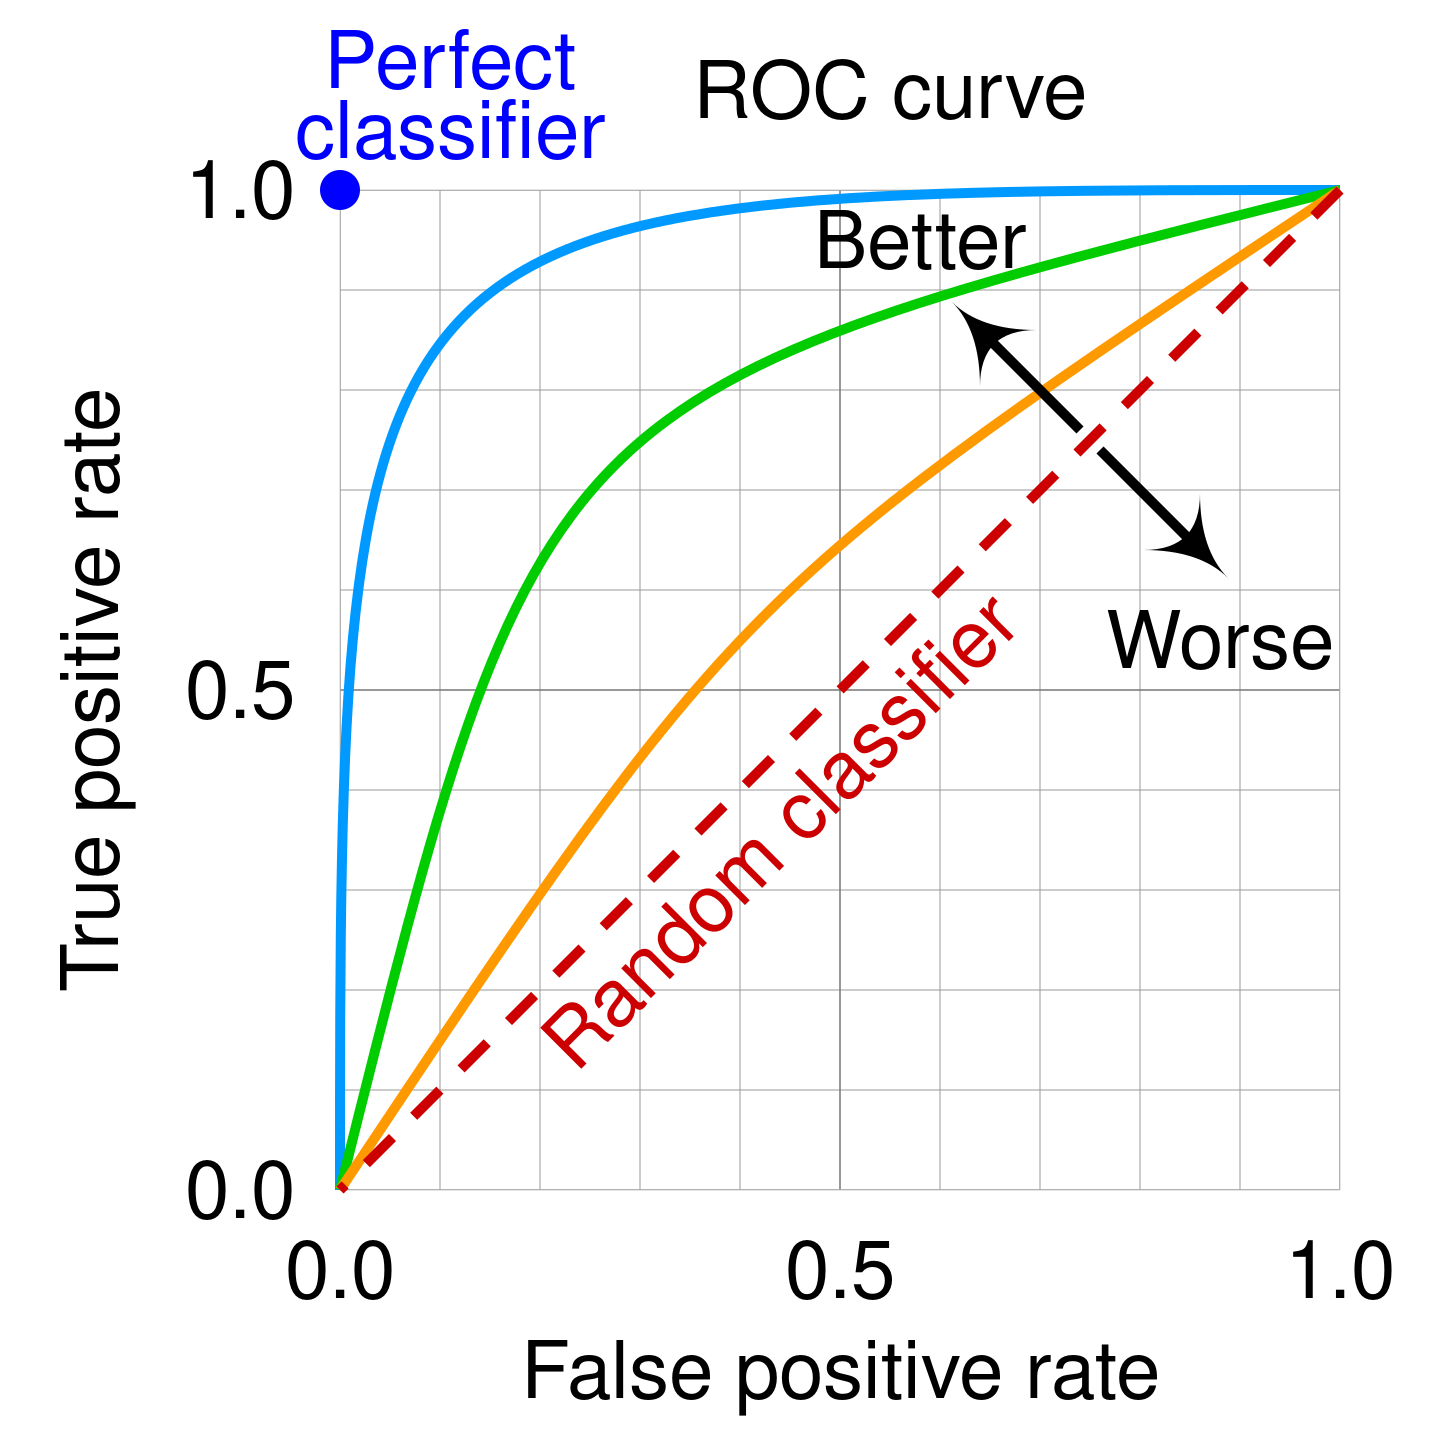
    
Each curve represents a model, where the curve shows how TPR and FPR at each threshold. The random model is a line $y=x$ because it will be (on average) predicting the same TPR as FPR.

However it is sometimes difficult to observe for which model the ROC curve gives best results, to get this info we find the area under the curve. (since a perfect model would have an area of 1). 
    
**This method should be used if we care only about ranking predictions and not about giving the probabilities.
 However there has been research [Takaya, Marc], indicating that if the class is skewed (i.e. positives>>negatives) this is not the best method.**
    <li>PR AUC</li>
This is similar to ROC AUC, but instead we use a Precision-Recall curve. I think of it as an alternative to ROC AUC **when the class is heavily skewed. This is also great when we want to decide which threshold to use.**
    
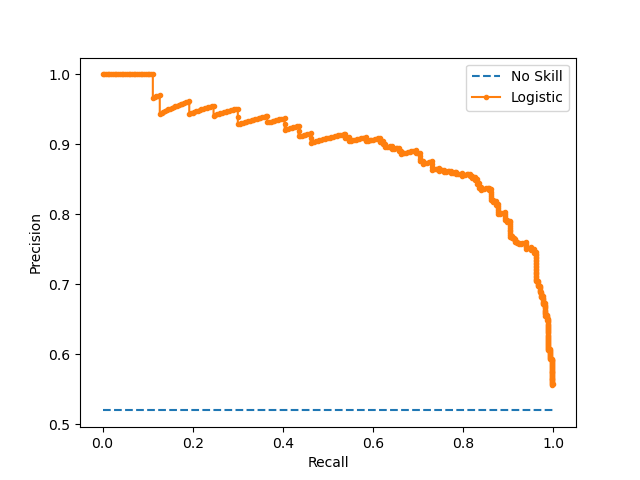
<ol>

## 10.1. Classification Reports

I will give a classification report and confusion matrix for KNN, SVC and XGBoost tuned with GridSearchCV. 

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report ,precision_score

In [ ]:
>>> y_true = [0, 1, 2, 2, 2]
>>> y_pred = [0, 0, 2, 2, 1]
>>> target_names = ['class 0', 'class 1', 'class 2']
>>> print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
print(classification_report(y_val,y_hat_knngridNOESESTO))
print(confusion_matrix(y_val,y_hat_knngridNOESESTO))

In [ ]:
print(classification_report(y_val,y_hat_svcgridNOESESTO))
print(confusion_matrix(y_val,y_hat_svcgridNOESESTO))

In [ ]:
print(classification_report(y_val,y_hat_xgbgridNOESESTO))
print(confusion_matrix(y_val,y_hat_sgbgridNOESESTO))

## 10.2. ROC curves

I will use ROC curves instead of PR curves since the class is not heavily skewed (there's a similar amount of 'survived' compared to 'not survived'.